In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from trcrpm import TRCRP_Mixture
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

In [4]:
data_clean = pd.read_csv("../data/data.csv", index_col=0)

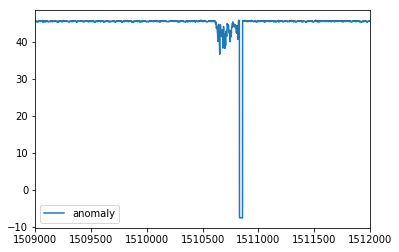

In [6]:
data_clean.plot()

In [14]:
offset = 0
n = 100
slicing = [ offset, offset + n, offset + 2*n, offset + 3*n, offset + 4*n]
data = pd.concat([data_clean.iloc[slicing[0]:slicing[1],0].reset_index(drop=True), 
                    data_clean.iloc[slicing[1]:slicing[2],0].reset_index(drop=True), 
                    data_clean.iloc[slicing[2]:slicing[3],0].reset_index(drop=True), 
                    data_clean.iloc[slicing[3]:slicing[4],0].reset_index(drop=True)], axis=1
                )
data.columns = [ "d1", "d2", "d3", "d4"]

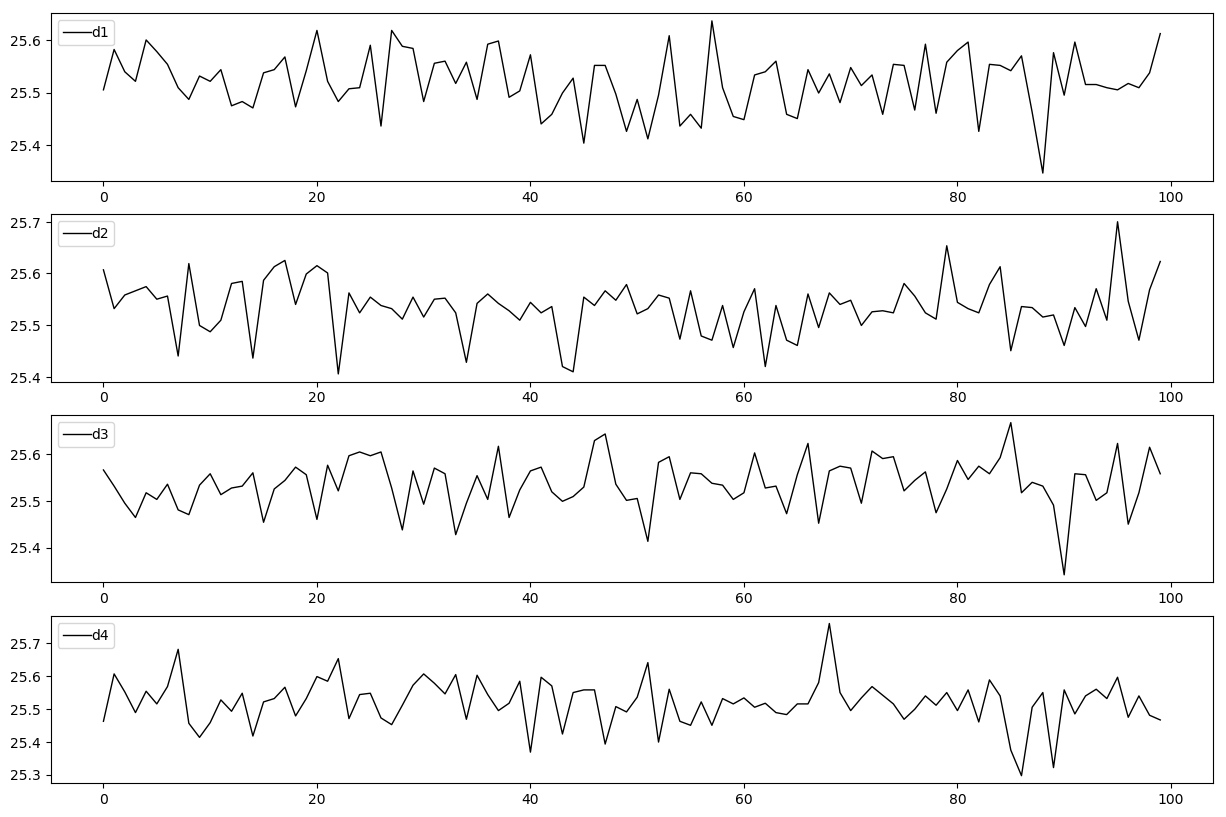

In [15]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(nrows=len(data.columns))
for ax, variable in zip(axes, data.columns):
    index = list(data.columns).index(variable)
    x_observed = data.index
    y_observed = data.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    ax.legend(loc='upper left', handletextpad=0)
#fig.set_size_inches(5,20)

In [16]:
rng = np.random.RandomState(1)
model = TRCRP_Mixture(chains=4, lag=10, variables=data.columns, rng=rng)
model.incorporate(data)
model.resample_all(seconds=20)
model.resample_hyperparameters(seconds=10)
probes = model.dataset.index
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

Completed: 154 iterations in 20.001731 seconds.
Completed: 164 iterations in 20.027455 seconds.
Completed: 21 iterations in 20.059360 seconds.
Completed: 11 iterations in 20.782289 seconds.
Completed: 79 iterations in 10.050505 seconds.
Completed: 48 iterations in 10.090759 seconds.
Completed: 2 iterations in 11.791577 seconds.
Completed: 3 iterations in 12.907204 seconds.06%


In [17]:
def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states==state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                alpha=0.3, color=color)

In [18]:
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    # Plot 25--75 percentile bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.fill_between(
        probes,
        np.percentile(samples, 25, axis=0),
        np.percentile(samples, 75, axis=0),
        color='gray',
        alpha=0.5)
    #  Optionally plot latent temporal state at each timepoint,
    #  according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

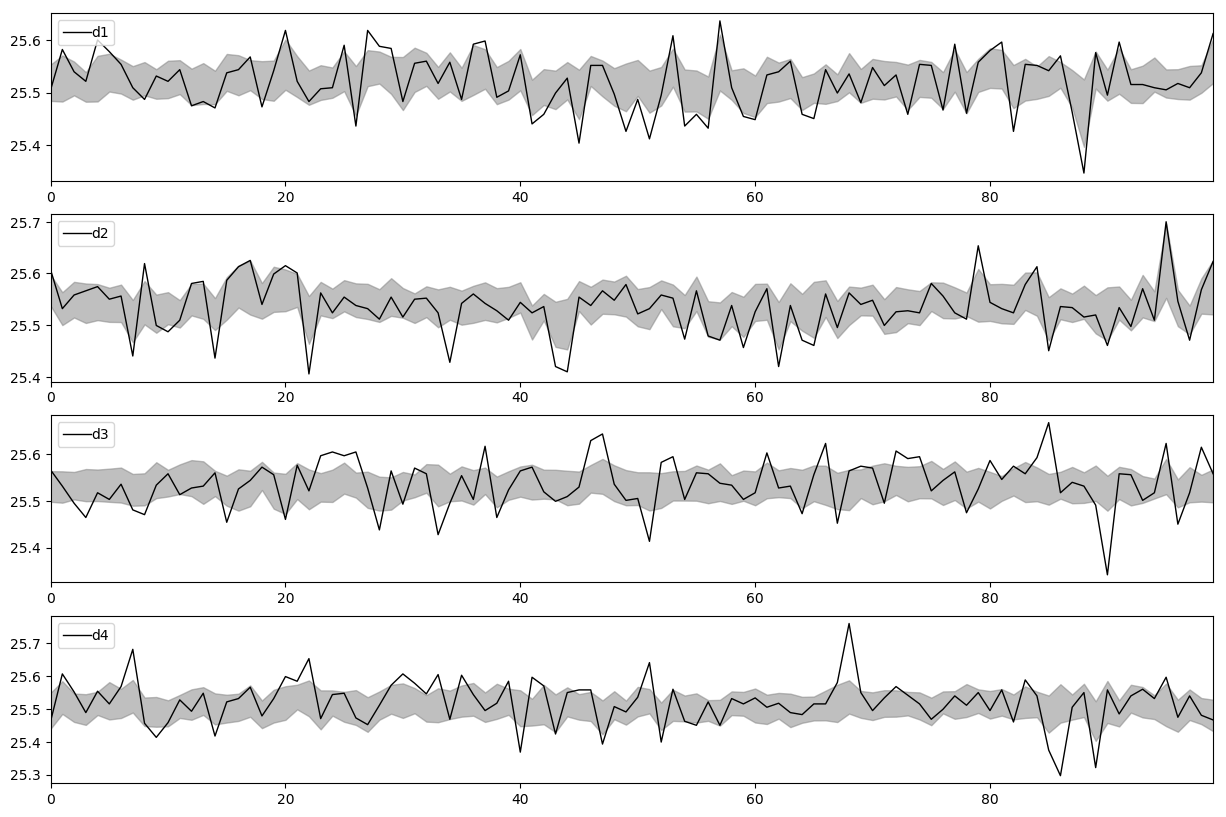

In [19]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(nrows=len(data.columns))
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples, variable, ax)
    ax.set_xlim([min(probes), max(probes)])

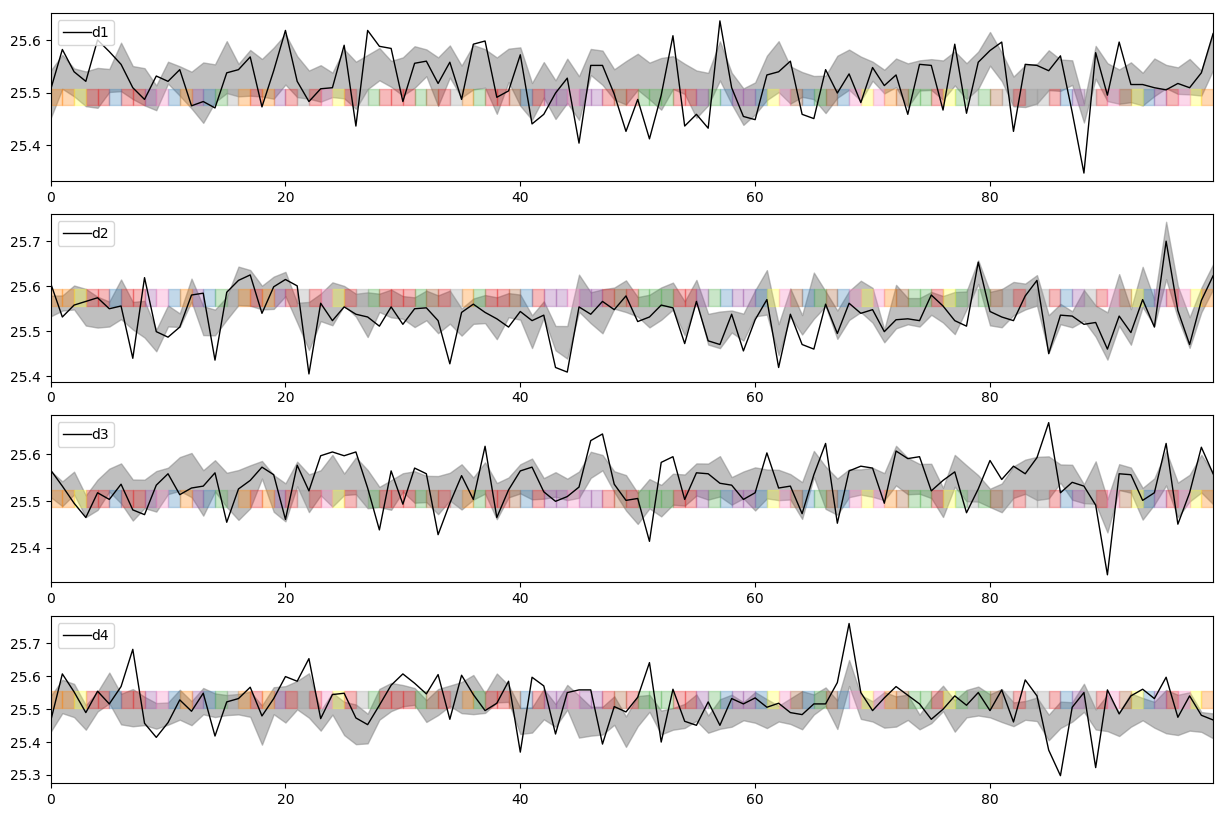

In [20]:
chain = 0
samples_chain = samples[numsamples*chain:numsamples*(chain+1)]
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples_chain, variable, ax, states_from_chain=chain)
    ax.set_xlim([min(probes), max(probes)])

In [24]:
probes = list(model.dataset.index) + range(max(model.dataset.index), max(model.dataset.index)+100)
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

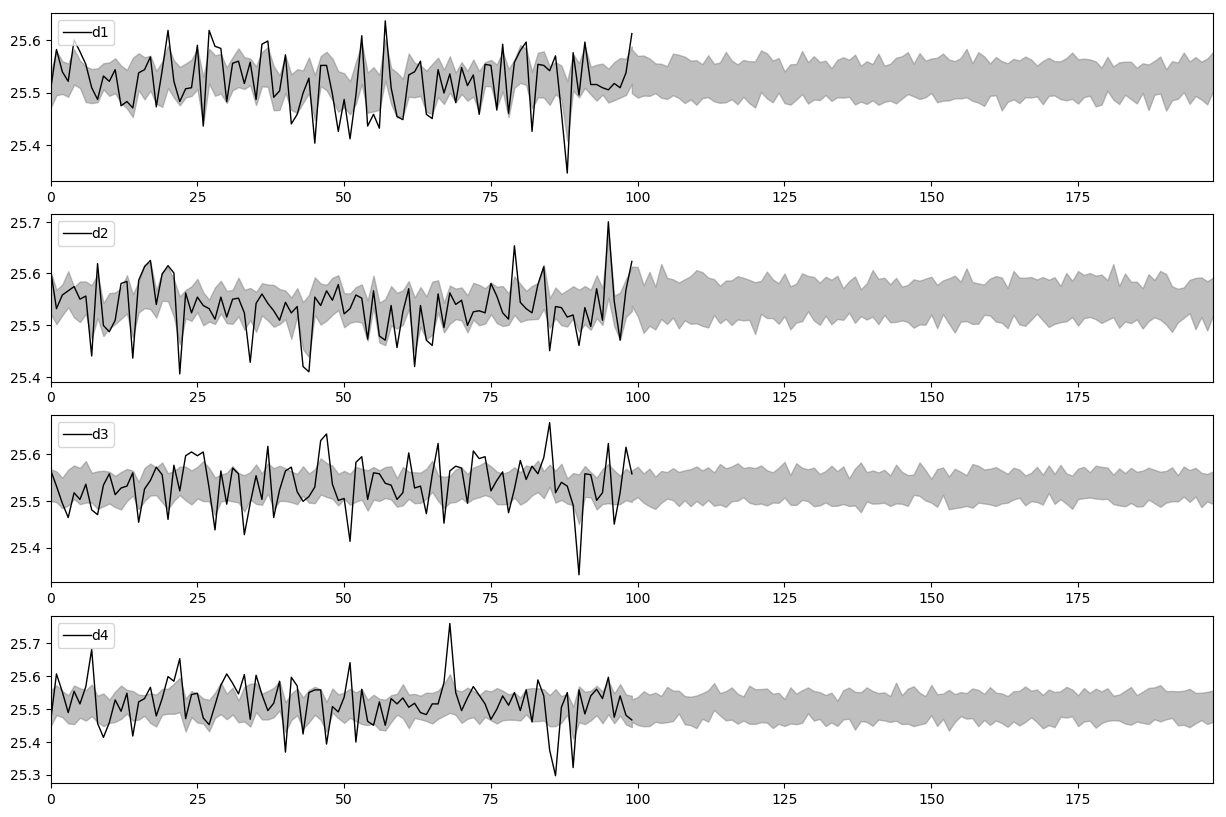

In [25]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples, variable, ax)
    ax.set_xlim([min(probes), max(probes)])